In [28]:
import pandas as pd

In [29]:
df=pd.read_excel("Online Retail.xlsx")
df.to_csv("Book1.csv")

In [30]:
df_copy = df

In [31]:
df = df_copy

In [32]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
199655,554098,21922,UNION STRIPE WITH FRINGE HAMMOCK,2,2011-05-22 13:01:00,7.95,14769.0,United Kingdom
177339,552057,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2011-05-06 10:34:00,7.95,17504.0,United Kingdom
517833,580094,23318,BOX OF 6 MINI VINTAGE CRACKERS,2,2011-12-01 14:50:00,2.49,15904.0,United Kingdom
253601,559163,23125,6PC WOOD PLATE SET DISPOSABLE,1,2011-07-06 16:33:00,2.46,NaN,United Kingdom
331726,566033,21989,PACK OF 20 SKULL PAPER NAPKINS,1,2011-09-08 13:07:00,0.85,16031.0,United Kingdom


In [33]:
df.shape

(541909, 8)

In [34]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df.dropna(subset=['InvoiceDate','UnitPrice','InvoiceNo','CustomerID'],inplace=True)
df.drop_duplicates(inplace=True)

In [35]:
df = df[df['Quantity'] > 0].copy()  
df['StockCode'] = df['StockCode'].astype(str).str[:5]
df['Price']=df['UnitPrice']*df['Quantity']

In [36]:
import datetime

snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

customer_df=df.groupby('CustomerID').agg({
    'InvoiceDate':lambda x:(snapshot_date-x.max()).days,
    'InvoiceNo': 'nunique',
    'Price':'sum'})

customer_df.columns = ['Recency', 'Frequency', 'Monetary']

customer_df['AOV']=customer_df['Monetary']/customer_df['Frequency']

In [37]:
from sklearn.model_selection import train_test_split

X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestRegressor

model= RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 191.60464221198183
RMSE: 2554.264264932329


In [40]:
# Predict LTV for all customers
customer_df['Predicted_LTV'] = model.predict(customer_df[X.columns])

customer_df['Segment'] = pd.qcut(customer_df['Predicted_LTV'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

In [41]:
customer_df.to_csv("predicted_LTV.csv")

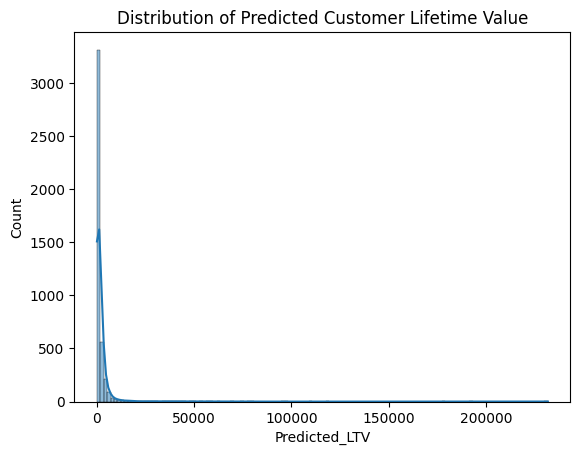

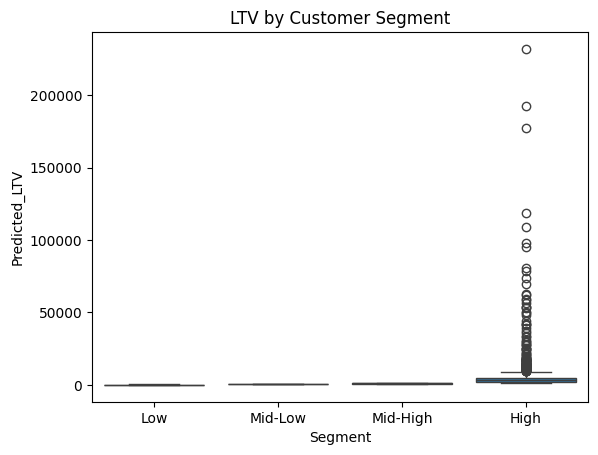

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(customer_df['Predicted_LTV'], kde=True)
plt.title("Distribution of Predicted Customer Lifetime Value")
plt.show()

sns.boxplot(x='Segment', y='Predicted_LTV', data=customer_df)
plt.title("LTV by Customer Segment")
plt.show()

In [43]:
import joblib

joblib.dump(model, 'customer_ltv_model.pkl')

['customer_ltv_model.pkl']

In [44]:
model_loaded = joblib.load('customer_ltv_model.pkl')
y_pred_loaded = model_loaded.predict(X_test)    

                              ----End of Project----